In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def read_files(directory='../data/data/'):
    return [files for files in os.listdir(directory)]

def last_observed_benchmark(filenames, start, end):
    '''
    For a given start and end index iterate through dataframes to fetch the latest item
    and return it as prediction for that range
    '''
    predictions = []
    for i in range(start, end):
        df = pd.read_csv('../data/data/'+ str(i) + '.csv')
        recent_observation = df.iloc[-1:, 0:198]
        predictions.append(recent_observation)
    
    recent_observations_df = pd.concat(predictions, axis=0)
    recent_observations_df = recent_observations_df.set_index(np.arange(start - 1, end - 1))
    
    return recent_observations_df

def loss(y, y_pred):
    e = abs(y - y_pred)
    return e

In [3]:
filenames = read_files()
recent_observation_df = last_observed_benchmark(filenames, 1, 201)

In [31]:
## load true values
trueLabels = pd.read_csv('../data/trainLabels.csv')
y_true = trueLabels.iloc[:, 1:]

In [34]:
## lets take a look at the loss metric
e = loss(y_true, recent_observation_df)

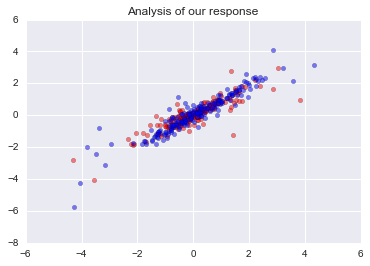

In [38]:
plt.scatter(y_true.iloc[:, 5], recent_observation_df.iloc[:, 5], c='r', alpha=.5)
plt.scatter(y_true.iloc[:, 6], recent_observation_df.iloc[:, 6], c='b', alpha=.5)
plt.title('Analysis of our response');

In [40]:
print 'Error on the training set is %f ' %e.mean(axis=1).mean()

Error on the training set is 0.440612 


## Visulization of the Price Movements

In [3]:
def concatenate_intra_day_results():
    """
    Concatenate intra day results for all the securities
    """
    predictions = []
    for i in range(1, 511):
        df = pd.read_csv('../data/data/'+ str(i) + '.csv')
        predictions.append(df)
    
    merged_df = pd.concat(predictions, axis=0)
    return merged_df

merged_df = concatenate_intra_day_results()

In [4]:
merged_df = merged_df.set_index(np.arange(0, 55 * 510))

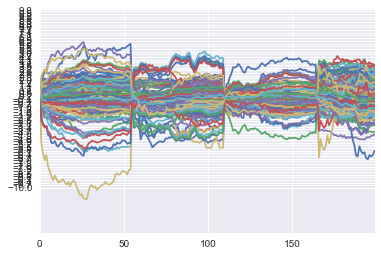

In [17]:
figure = plt.figure(figsize=(20, 20))
merged_df.iloc[: 200, :198].plot(legend=False, figsize=(20, 20))
plt.yticks(np.arange(-10, 10, .3))
plt.show();

### How does error varies if we vary how many days we take into account ?

In [125]:
def error_variation(dfs, y_true, func, days_to_consider=10):
    """
    Takes in range of days that we should consider for prediction
    Last Observed is a special case with num_days = 1
    """
    recent_observations = []
    errors = []
    
    for i in range(1, days_to_consider):
        recent_observations = []
        for j in range(len(dfs)):
            df = dfs[j]
            observation = df.iloc[(-1*i):, 0:198].apply(func, axis=0)
            recent_observations.append(observation)
        
        recent_obs_df = pd.concat(recent_observations, axis=1)
        recent_obs_df = recent_obs_df.T
        e = abs(y_true - recent_obs_df)
        errors.append(e.mean(axis=1).mean())
    
    return errors

def create_training_set():
    training_dfs = []
    for i in range(1, 201):
        training_dfs.append(pd.read_csv('../data/data/' + str(i) + '.csv'))
    
    return training_dfs

training_dfs = create_training_set()
errors_mean = error_variation(training_dfs, y_true, np.mean)
errors_median = error_variation(training_dfs, y_true, np.median)

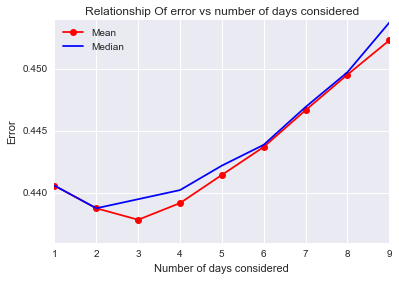

In [129]:
plt.plot(np.arange(1, 10), errors_mean, label='Mean', c='r', marker='o')
plt.plot(np.arange(1, 10), errors_median, label='Median', c='b')
plt.xlabel('Number of days considered')
plt.ylabel('Error')
plt.title('Relationship Of error vs number of days considered')
plt.legend(loc='best');

In [132]:
def create_test_set():
    test_dfs = []
    for i in range(201, 511):
        test_dfs.append(pd.read_csv('../data/data/' + str(i) + '.csv'))
    
    return test_dfs

def get_prediction_df(dfs, days_to_consider=3):
    recent_observations = []
    for j in range(len(dfs)):
        df = dfs[j]
        observation = df.iloc[(-1*days_to_consider):, 0:198].apply(np.mean, axis=0)
        recent_observations.append(observation)

    recent_obs_df = pd.concat(recent_observations, axis=1)
    recent_obs_df = recent_obs_df.T
    
    return recent_obs_df


test_dfs = create_test_set()
prediction_matrix = get_prediction_df(test_dfs)

## Analysis with the multiplication factor

In [159]:
def prepare_dfs(dfs, func, days_to_consider=1):
    recent_observations = []
    
    for j in range(len(dfs)):
        df = dfs[j]
        observation = df.iloc[(-1*days_to_consider):, 0:198].apply(func, axis=0)
        recent_observations.append(observation)

    recent_obs_df = pd.concat(recent_observations, axis=1)
    recent_obs_df = recent_obs_df.T
    
    return recent_obs_df

In [156]:
def error_variation_weights(recent_obs_df, y_true, Q_weights):
    """
    Takes in different weights and checks to see how it would affect
    error
    """
    errors = []
    
    for i in range(len(Q_weights)):
        e = abs(y_true - (Q_weights[i] * recent_obs_df))
        errors.append(e.mean(axis=1).mean())
    
    return errors

Q_weights = np.arange(.9, 1.1, 0.001)
recent_obs_df = prepare_dfs(training_dfs, np.mean)
errors_mean = error_variation_weights(recent_obs_df, y_true, Q_weights)

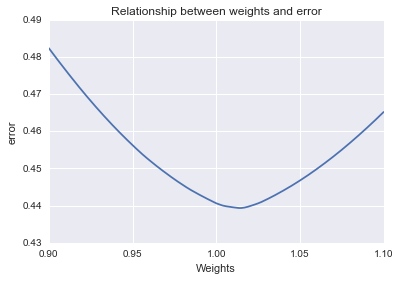

In [157]:
plt.plot(Q_weights, errors_mean)
plt.xlabel('Weights')
plt.ylabel('error')
plt.title('Relationship between weights and error');

## Linear Regression Model

In [170]:
from sklearn.linear_model import LinearRegression

In [171]:
def prepare_dfs(dfs, func, days_to_consider=1):
    recent_observations = []
    
    for j in range(len(dfs)):
        df = dfs[j]
        observation = df.iloc[(-1*days_to_consider):, 0:198].apply(func, axis=0)
        recent_observations.append(observation)

    recent_obs_df = pd.concat(recent_observations, axis=1)
    recent_obs_df = recent_obs_df.T
    
    return recent_obs_df

recent_obs_df = prepare_dfs(training_dfs, np.mean)

In [204]:
def leave_one_out(dfs, y_true):
    model = LinearRegression()
    y_preds = np.zeros((dfs.shape[0], dfs.shape[1]))
    errors = []
    
    for i in range(0, 2):
        for j in range(0, 1):
            X = dfs.drop(dfs.index[i])
            y = y_true.drop(y_true.index[i])
            print 'shape of training set ', X.shape
            print 'shape of test set ', y.shape
            
            model.fit(X, y.iloc[:, j])
            y_preds[i, j] = model.predict(dfs.iloc[i])
        errors.append(y_preds[i])
    
    return errors

In [205]:
error_linear_regression = leave_one_out(recent_obs_df, y_true)

shape of training set  (199, 198)
shape of test set  (199, 198)
shape of training set  (199, 198)
shape of test set  (199, 198)


/Users/abhishek/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/abhishek/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [208]:
len(error_linear_regression[0])

198

In [199]:
a = pd.DataFrame([[1, 2, 3], [4, 5, 6]])

In [200]:
a

,0,1,2
0,1,2,3
1,4,5,6


In [201]:
a.drop(a.index[0])

,0,1,2
1,4,5,6


In [198]:
np.delete(a, 0)

array([1, 2, 3, 4, 5])

In [187]:
a

array([1, 2, 3])

## Prepare submission

In [161]:
prediction_matrix = prepare_dfs(test_dfs, np.mean)

In [163]:
prediction_matrix_weight_balanced = (1.014) * prediction_matrix

In [164]:
prediction_matrix.head()

,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,...,O189,O190,O191,O192,O193,O194,O195,O196,O197,O198
0,-3.82,-0.88,0.54,0.08,-1.65,-2.80,-1.74,-5.16,-4.58,-5.23,...,-1.16,-3.50,-2.83,-2.03,-1.53,-2.50,-3.14,-6.31,-4.71,-3.53
1,6.79,-1.90,-0.65,0.14,-0.08,-1.74,-0.86,-1.17,-1.91,-0.50,...,-0.95,-2.09,-1.44,-0.67,-1.78,-2.33,-2.04,-5.38,-5.58,-2.60
2,2.06,-0.11,0.37,-0.13,0.36,0.82,0.97,1.61,1.14,2.93,...,0.42,0.99,0.47,0.29,-0.05,0.50,0.37,0.88,0.93,0.67
3,-0.62,-0.06,0.08,0.26,-0.37,0.26,7.22,-0.29,0.79,-1.71,...,0.09,0.26,-0.08,0.45,0.67,0.22,0.38,0.96,-0.42,1.06
4,-0.91,-0.84,-0.40,0.44,-2.77,-1.44,-1.72,-2.17,-3.19,-2.51,...,-0.89,-1.34,-1.77,-1.55,-1.16,-1.28,-1.35,-2.40,-2.61,-1.30


## Submission

In [166]:
recent_observation_df_test = prediction_matrix_weight_balanced.set_index(np.arange(0, 310))

In [167]:
submission = pd.read_csv('../data/sampleSubmission.csv')

In [168]:
submission.iloc[:, 1:] = recent_observation_df_test

In [169]:
submission.to_csv('../submissions/weight_balanced.csv', index=False)